In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention,
    Add, Activation, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# dataset directory
dataset_dir = "../real-dataset/compiled/"

# load and preprocess the dataset without batching
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=None,  # ← KEY CHANGE: No batching yet
    shuffle=True,
    seed=42  # For reproducibility
)

Found 545 files belonging to 5 classes.


In [2]:
# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2, batch_size=32):
    total_size = dataset.cardinality().numpy()

    train_count = int(total_size * train_size)
    val_count = int(total_size * val_size)
    test_count = total_size - train_count - val_count

    # Split BEFORE batching
    train_dataset = dataset.take(train_count).batch(batch_size)
    val_test_dataset = dataset.skip(train_count)
    val_dataset = val_test_dataset.take(val_count).batch(batch_size)
    test_dataset = val_test_dataset.skip(val_count).batch(batch_size)

    print(f"Dataset split finished: {train_count} train, {val_count} val, {test_count} test samples.")
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data, batch_size=32)

# Prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

Dataset split finished: 381 train, 109 val, 55 test samples.


In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Collect all labels from the training set
train_labels = []
for _, labels in train.unbatch():  # unbatch to get single samples
    train_labels.append(labels.numpy())

train_labels = np.array(train_labels)
print(f"Collected {len(train_labels)} training labels.")

# Compute class weights
classes = np.unique(train_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_labels)
class_weight_dict = dict(zip(classes, class_weights))

# Debug output
print("class weights calculation:")
for cls, weight in class_weight_dict.items():
    print(f"  Class {cls}: {weight:.4f}")

Collected 381 training labels.
class weights calculation:
  Class 0: 0.8562
  Class 1: 0.6145
  Class 2: 1.6933
  Class 3: 1.8585
  Class 4: 0.9293


Counting original training set classes (this may take a moment)...
Creating augmented dataset and concatenating...
Counting augmented training set classes...

--- Augmentation Impact Analysis ---
Class                | Before     | After      | Increase  
-------------------------------------------------------
First Degree         | 98         | 186        | 88        
Second Degree        | 110        | 228        | 118       
Third Degree         | 44         | 85         | 41        
Fourth Degree        | 37         | 78         | 41        
Normal Skin          | 92         | 185        | 93        
-------------------------------------------------------


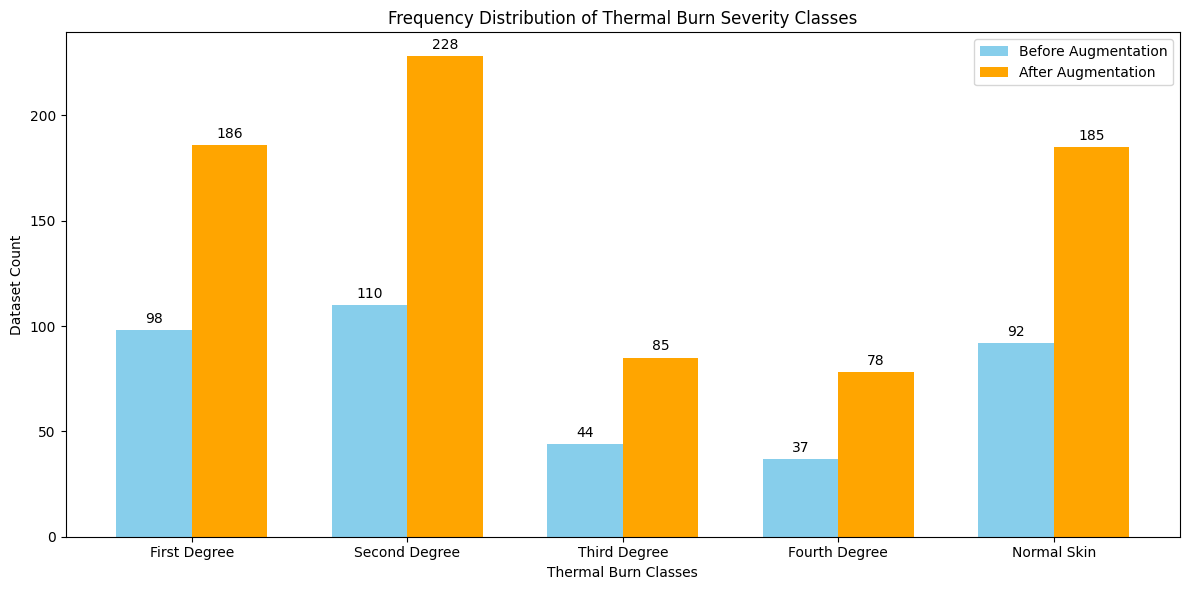

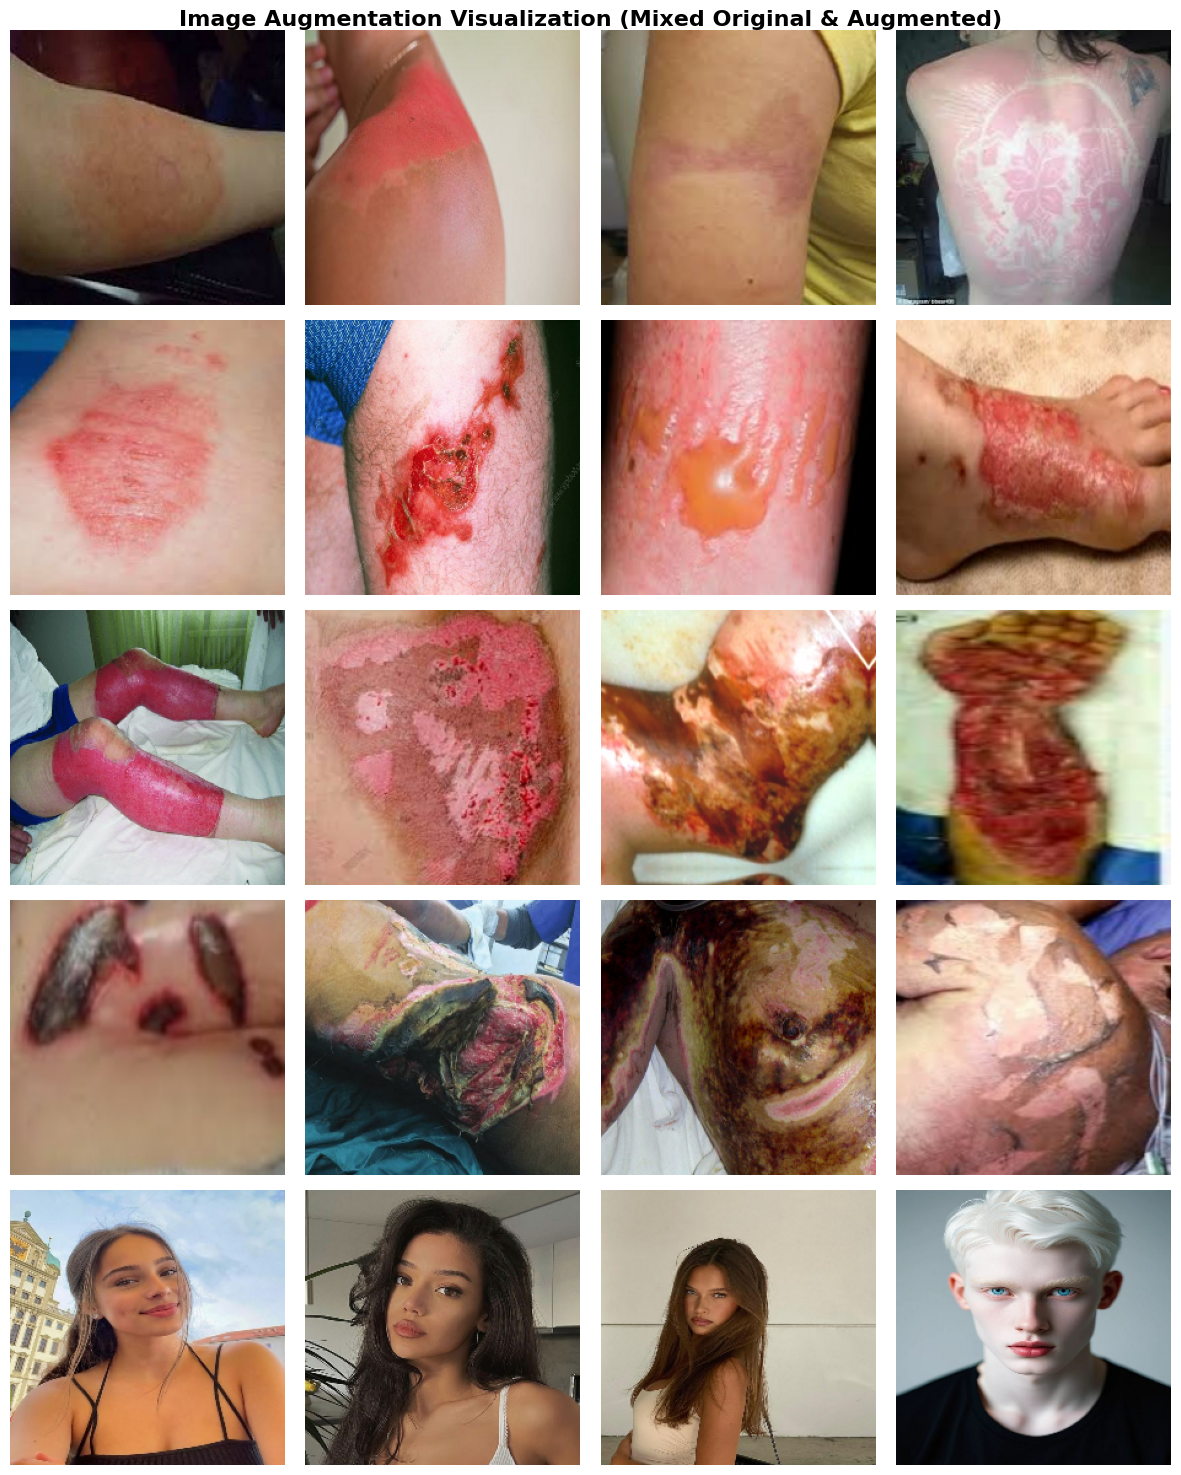

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

# Define class labels
class_labels = {
    0: 'First Degree',
    1: 'Second Degree',
    2: 'Third Degree',
    3: 'Fourth Degree',
    4: 'Normal Skin'
}

# Function to count samples per class
def get_class_counts(dataset):
    counts = {k: 0 for k in class_labels.keys()}
    # Iterate over batches
    for _, batch_labels in dataset:
        for label in batch_labels.numpy():
            label = int(label)
            if label in counts:
                counts[label] += 1
    return counts

print("Counting original training set classes (this may take a moment)...")
counts_before = get_class_counts(train)

# Advanced augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.GaussianNoise(0.01),
], name='data_augmentation')

# Apply augmentation
# We create a new dataset with augmented images and concatenate it to the original
print("Creating augmented dataset and concatenating...")
augmented_train = train.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# Concatenate original and augmented datasets
# This effectively doubles the dataset size
train = train.concatenate(augmented_train)

# Shuffle the combined dataset
train = train.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

print("Counting augmented training set classes...")
counts_after = get_class_counts(train)

# Display comparison
print("\n--- Augmentation Impact Analysis ---")
print(f"{'Class':<20} | {'Before':<10} | {'After':<10} | {'Increase':<10}")
print("-" * 55)
for cls in class_labels:
    name = class_labels[cls]
    before = counts_before[cls]
    after = counts_after[cls]
    print(f"{name:<20} | {before:<10} | {after:<10} | {after - before:<10}")
print("-" * 55)

# Bar Graph Visualization
labels = [class_labels[i] for i in range(len(class_labels))]
before_values = [counts_before[i] for i in range(len(class_labels))]
after_values = [counts_after[i] for i in range(len(class_labels))]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, before_values, width, label='Before Augmentation', color='skyblue')
rects2 = ax.bar(x + width/2, after_values, width, label='After Augmentation', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dataset Count')
ax.set_xlabel('Thermal Burn Classes')
ax.set_title('Frequency Distribution of Thermal Burn Severity Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

# Visualize 4 random augmented images per category
num_per_class = 4
samples = {k: [] for k in class_labels.keys()}

# Note: We unbatch to visualize individual images
for images, labels in train.unbatch().take(500): # Take a subset to speed up
    label = int(labels.numpy())
    if label in samples and len(samples[label]) < num_per_class:
        samples[label].append(images)
    # Stop when all classes have enough samples
    if all(len(v) == num_per_class for v in samples.values()):
        break

plt.figure(figsize=(num_per_class * 3, len(class_labels) * 3))
for class_idx, (cat, imgs) in enumerate(samples.items()):
    for i, img in enumerate(imgs):
        if i < len(imgs):
            ax = plt.subplot(len(class_labels), num_per_class, class_idx * num_per_class + i + 1)
            img = tf.clip_by_value(img, 0, 255)
            plt.imshow(img.numpy().astype("uint8"))
            if i == 0:
                ax.set_ylabel(class_labels[cat], fontsize=12, fontweight='bold')
            plt.axis("off")
plt.suptitle("Image Augmentation Visualization (Mixed Original & Augmented)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


TensorFlow Version: 2.20.0
Preparing for K-Fold Cross-Validation (Hybrid MobileNetV2 + Transformer)...
Loading all images into memory (this ensures consistent splits)...
Total Dataset Shape: (545, 224, 224, 3)
Total Labels Shape: (545,)

Starting 5-Fold Cross-Validation...

==================== Fold 1/5 ====================
  Augmenting training fold (436 samples)...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 700ms/step - accuracy: 0.5585 - loss: 2.2676 - val_accuracy: 0.6239 - val_loss: 1.2843 - learning_rate: 0.0010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 593ms/step - accuracy: 0.7959 - loss: 0.6303 - val_accuracy: 0.6239 - val_loss: 1.1137 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 615ms/step - accuracy: 0.9014 - loss: 0.2448 - val_accuracy: 0.8165 - val_loss: 1.1281 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 667ms/step - accuracy: 0.9243 - loss: 0.2065 - val_accuracy: 0.7431 - val_loss: 1.7358 - learning_rate: 0.0010
Epoch 5/20
28/28 

  Fold 1 Result -> Accuracy: 0.6239
  New best model found! (Acc: 0.6239)

==================== Fold 2/5 ====================
  Augmenting training fold (436 samples)...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 681ms/step - accuracy: 0.6227 - loss: 1.4276 - val_accuracy: 0.6606 - val_loss: 1.5763 - learning_rate: 0.0010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 643ms/step - accuracy: 0.8383 - loss: 0.5224 - val_accuracy: 0.6606 - val_loss: 2.4162 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 658ms/step - accuracy: 0.8842 - loss: 0.4819 - val_accuracy: 0.6881 - val_loss: 3.0463 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 631ms/step - accuracy: 0.9312 - loss: 0.2705 - val_accuracy: 0.6147 - val_loss: 2.4934 - learning_rate: 0.0010
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - accuracy: 0.9644 - loss: 0.1032 - val_accuracy: 0.6881 - val_loss: 2.6445 - learning_rate: 5.0000e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 632ms/step - accura

  Fold 2 Result -> Accuracy: 0.6606
  New best model found! (Acc: 0.6606)

==================== Fold 3/5 ====================
  Augmenting training fold (436 samples)...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 743ms/step - accuracy: 0.5608 - loss: 1.7795 - val_accuracy: 0.7248 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 632ms/step - accuracy: 0.8234 - loss: 0.5323 - val_accuracy: 0.7615 - val_loss: 1.0820 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 689ms/step - accuracy: 0.9106 - loss: 0.2610 - val_accuracy: 0.7615 - val_loss: 1.2987 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 644ms/step - accuracy: 0.9610 - loss: 0.2158 - val_accuracy: 0.7615 - val_loss: 2.3453 - learning_rate: 0.0010
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 633ms/step - accuracy: 0.9622 - loss: 0.1462 - val_accuracy: 0.7248 - val_loss: 2.1892 - learning_rate: 5.0000e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 651ms/step - accura

  Fold 3 Result -> Accuracy: 0.7248
  New best model found! (Acc: 0.7248)

==================== Fold 4/5 ====================
  Augmenting training fold (436 samples)...
Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 692ms/step - accuracy: 0.5550 - loss: 2.1752 - val_accuracy: 0.6881 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 652ms/step - accuracy: 0.8177 - loss: 0.5692 - val_accuracy: 0.6422 - val_loss: 1.8559 - learning_rate: 0.0010
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 664ms/step - accuracy: 0.9186 - loss: 0.3294 - val_accuracy: 0.6606 - val_loss: 1.9475 - learning_rate: 0.0010
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 662ms/step - accuracy: 0.9679 - loss: 0.1041 - val_accuracy: 0.6697 - val_loss: 2.1409 - learning_rate: 0.0010
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 700ms/step - accuracy: 0.9931 - loss: 0.0172 - val_accuracy: 0.7064 - val_loss: 2.0941 - learning_rate: 5.0000e-04
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 714ms/step - accura

  Fold 5 Result -> Accuracy: 0.7615
  New best model found! (Acc: 0.7615)

K-FOLD CROSS-VALIDATION RESULTS
Average Accuracy:  0.6917 (+/- 0.0481)
Average Precision: 0.6889
Average Recall:    0.6694
----------------------------------------
Best Single Fold Accuracy: 0.7615
Best Model Saved to: ../real-checkpoints/hybrid/kfold_best_model_mobilenet_transformer.h5

Visualizing Confusion Matrix for the last fold...


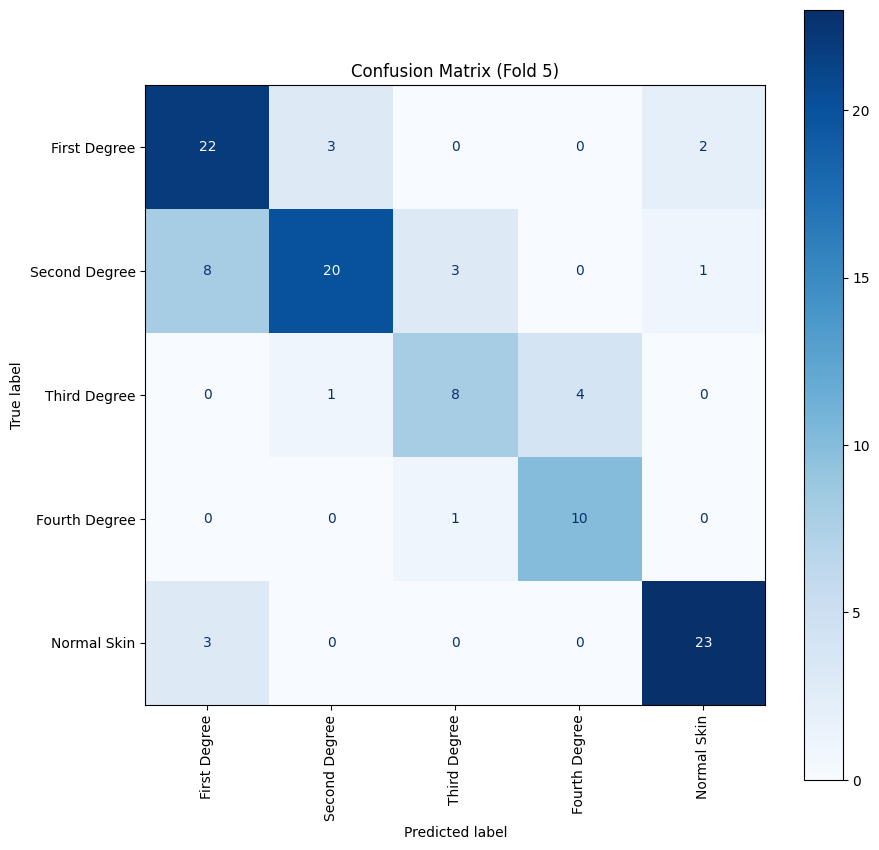

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling1D, Dense, Dropout, Input, Lambda,
    LayerNormalization, MultiHeadAttention, Add, Reshape
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
import os

# Clear session
tf.keras.backend.clear_session()

print(f"TensorFlow Version: {tf.__version__}")
print("Preparing for K-Fold Cross-Validation (Hybrid MobileNetV2 + Transformer)...")

# --- 1. Prepare Data (Convert to NumPy) ---
# We need the full dataset in memory to split it manually for K-Fold
print("Loading all images into memory (this ensures consistent splits)...")
X_all = []
y_all = []

# 'data' comes from Cell 1. We iterate to extract images/labels.
for img, label in data:
    X_all.append(img.numpy())
    y_all.append(label.numpy())

X_all = np.array(X_all)
y_all = np.array(y_all)
print(f"Total Dataset Shape: {X_all.shape}")
print(f"Total Labels Shape: {y_all.shape}")

# --- 2. Define Mode Builder ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_hybrid_model(input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)
    x = Lambda(preprocess_input)(inputs)

    # Use MobileNetV2
    base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    base_model.trainable = False

    x = base_model(x)
    # MobileNetV2 output is 7x7x1280 for input 224x224, so we reshape to (49, 1280)
    x = Reshape((49, 1280))(x)

    for _ in range(2):
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs)

# --- 3. K-Fold Configuration ---
K = 5
kfold = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

# Store results
fold_accuracies = []
fold_precisions = []
fold_recalls = []

# To store aggregated predictions across all folds
y_true_all_folds = []
y_pred_all_folds = []

best_accuracy = 0.0

print(f"\nStarting {K}-Fold Cross-Validation...")

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_all, y_all)):
    print(f"\n{'='*20} Fold {fold+1}/{K} {'='*20}")

    # Split Data
    X_train, X_val = X_all[train_idx], X_all[val_idx]
    y_train, y_val = y_all[train_idx], y_all[val_idx]

    # --- Augmentation (Applied to Training Fold Only) ---
    print(f"  Augmenting training fold ({len(X_train)} samples)...")
    X_train_aug = data_augmentation(X_train, training=True).numpy()

    # Concatenate Original + Augmented
    X_train_final = np.concatenate([X_train, X_train_aug])
    y_train_final = np.concatenate([y_train, y_train]) # Labels are same

    # Shuffle the training data for this fold
    perm = np.random.permutation(len(X_train_final))
    X_train_final = X_train_final[perm]
    y_train_final = y_train_final[perm]

    # --- Class Weights ---
    classes = np.unique(y_train_final)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train_final)
    class_weight_dict = dict(zip(classes, class_weights))

    # --- Build & Train ---
    tf.keras.backend.clear_session()
    model = build_hybrid_model()
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weight_dict,
        verbose=1
    )

    # --- Evaluate ---
    y_pred_prob = model.predict(X_val, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Accumulate for Global K-Fold Metrics
    y_true_all_folds.extend(y_val)
    y_pred_all_folds.extend(y_pred)

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_val, y_pred, average='macro', zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)

    print(f"  Fold {fold+1} Result -> Accuracy: {acc:.4f}")

    # Save best model
    if acc > best_accuracy:
        best_accuracy = acc
        print(f"  New best model found! (Acc: {acc:.4f})")

        save_path = f'../real-checkpoints/hybrid/kfold_best_model_mobilenet_transformer.h5'
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        model.save(save_path)

# --- 4. Final Results ---
print("\n" + "="*40)
print("K-FOLD CROSS-VALIDATION RESULTS (Averaged)")
print("="*40)
print(f"Average Accuracy:  {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print(f"Average Precision: {np.mean(fold_precisions):.4f}")
print(f"Average Recall:    {np.mean(fold_recalls):.4f}")
print("-" * 40)
print(f"Best Single Fold Accuracy: {best_accuracy:.4f}")
print(f"Best Model Saved to: ../real-checkpoints/hybrid/kfold_best_model_mobilenet_transformer.h5")

display_labels = [class_labels[i] for i in range(len(class_labels))]

# --- 5. Aggregated K-Fold Metrics ---
print("\n" + "="*40)
print("AGGREGATED K-FOLD METRICS (All Folds Combined)")
print("="*40)

# Aggregated Confusion Matrix
print("\n--- Aggregated Confusion Matrix ---")
cm_agg = confusion_matrix(y_true_all_folds, y_pred_all_folds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_agg, display_labels=display_labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title(f'Aggregated Confusion Matrix ({K}-Fold CV)')
plt.show()

# Aggregated Classification Report
print("\n--- Aggregated Classification Report ---")
print(classification_report(y_true_all_folds, y_pred_all_folds, target_names=display_labels))

Loading best model from: ../real-checkpoints/hybrid/kfold_best_model_mobilenet_transformer.h5
Standard load failed, trying with custom_objects: Could not locate function 'preprocess_input'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'builtins', 'class_name': 'function', 'config': 'preprocess_input', 'registered_name': 'function'}


Preparing Test Data from 'test' split...
Test Data Shape: (55, 224, 224, 3)
Making Predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step

--- Confusion Matrix ---


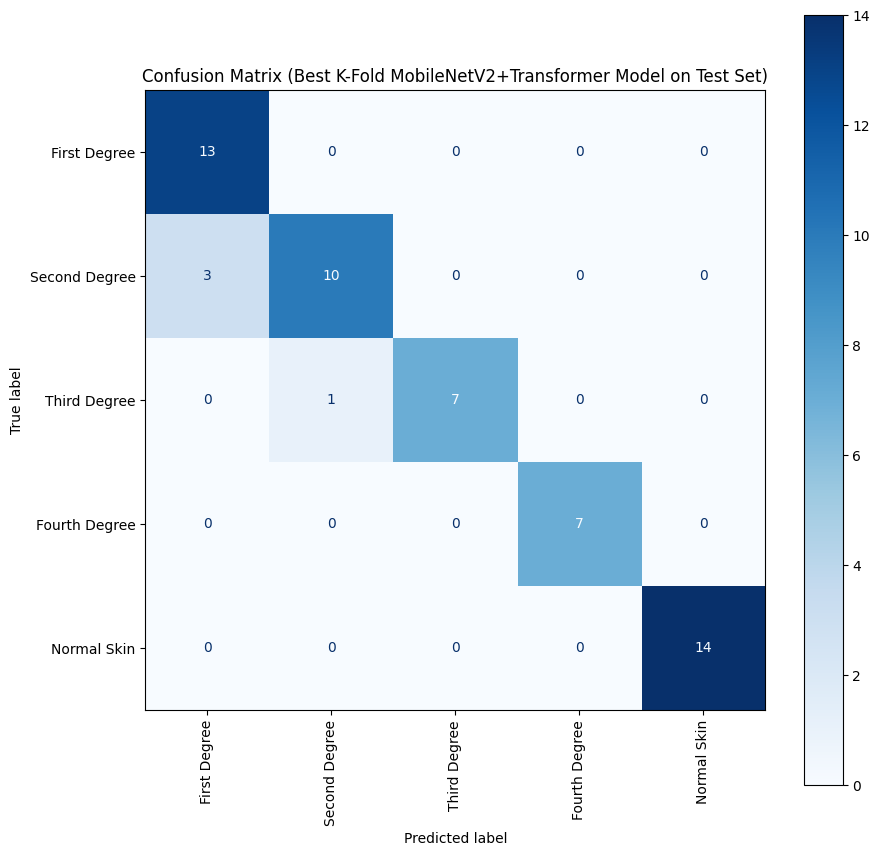


--- Classification Report ---
               precision    recall  f1-score   support

 First Degree       0.81      1.00      0.90        13
Second Degree       0.91      0.77      0.83        13
 Third Degree       1.00      0.88      0.93         8
Fourth Degree       1.00      1.00      1.00         7
  Normal Skin       1.00      1.00      1.00        14

     accuracy                           0.93        55
    macro avg       0.94      0.93      0.93        55
 weighted avg       0.93      0.93      0.93        55


--- Per-Class Accuracy ---
First Degree: 100.00%
Second Degree: 76.92%
Third Degree: 87.50%
Fourth Degree: 100.00%
Normal Skin: 100.00%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# 1. Load the Best Model
model_path = '../real-checkpoints/hybrid/kfold_best_model_mobilenet_transformer.h5'

if not os.path.exists(model_path):
    print(f"Error: Model not found at {model_path}. Please run the K-Fold training (Cell 5) first.")
else:
    print(f"Loading best model from: {model_path}")
    try:
        # We need to import the custom objects used in the model
        best_model = load_model(model_path)
    except Exception as e:
        print(f"Standard load failed, trying with custom_objects: {e}")
        # Note: If you saved the model with custom layers (like Transformer), you might need to
        # re-define/pass them here or ensure they are serializable.
        # Since we used functional API with standard layers + Keras layers, often it loads fine
        # if the environment matches. If not, we might need custom_object scope.
        best_model = load_model(model_path, custom_objects={'preprocess_input': preprocess_input})

    # 2. Prepare Test Data
    # We use the 'test' dataset defined in Cell 2
    print("Preparing Test Data from 'test' split...")
    X_test = []
    y_test = []

    # Iterate over the 'test' dataset to extract all data
    for images, labels in test.unbatch():
        X_test.append(images.numpy())
        y_test.append(labels.numpy())

    X_test = np.array(X_test)
    y_test = np.array(y_test)
    print(f"Test Data Shape: {X_test.shape}")

    # 3. Make Predictions
    print("Making Predictions...")
    y_pred_probs = best_model.predict(X_test, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 4. Detailed Metrics
    print("\n" + "="*40)
    print("BEST MODEL EVALUATION (Test Set)")
    print("="*40)

    # Calculate Macro Average Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # 5. Confusion Matrix
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    display_labels = [class_labels[i] for i in range(len(class_labels))]

    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
    plt.title('Confusion Matrix (Best MobileNetV2+Transformer Model on Test Set)')
    plt.show()

    # 6. Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=display_labels))

    # 7. Per-Class Accuracy
    print("\n--- Per-Class Accuracy ---")
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(class_accuracy):
        print(f"{display_labels[i]}: {acc:.2%}")